# Growth limitation in ESM4 piControl
Here, we calculate the correlation coefficients between NPP and the growth limitation factors for each of the different phytoplankton types.

In [1]:
import esm4ppe
import xarray as xr
import numpy as np
import gfdl_utils as gu
from dask.diagnostics import ProgressBar

## Load control simulation

In [2]:
zarrpath = esm4ppe.sysconfig['zarrpathroot']+'control_zarr/'+esm4ppe.get_zarrdir('limirrdiat','monthly')
ds = xr.open_zarr(zarrpath)
ds

<xarray.Dataset>
Dimensions:     (time: 3600, yh: 576, xh: 720, nv: 2, xq: 720, yq: 576, zl: 75)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0101-01-16 12:00:00 ... 0400-12-16 12:00:00
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq          (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq          (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.58 89.79 90.0
  * zl          (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Data variables: (12/25)
    dfeos       (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    intpp       (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    intppdiat   (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    intppdiaz   (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    intppmisc   (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    intpppico   (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    ...          ...
    limpmisc    (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    limppico    (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    no3os       (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    po4os       (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(3600, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(60, 576, 720), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 01010101.ocean_static.nc
    filename:          01010101.ocean_cobalt_omip_2d.nc
    grid_tile:         N/A
    grid_type:         regular
    history:           2022-03-14 16:55:32 -0400: PostProcessing::PPNetCDF::t...
    title:             ESM4_piControl_D

In [3]:
grid = esm4ppe.open_static('limirrdiat','monthly')

## Calculate Pearson correlation coefficient

In [4]:
def calc_pearson(da1,da2,dim='time',deseasonalize=True,detrend=True):
    var1 = da1.name
    var2 = da2.name
    savefilelist = ['pearson',var1,var2]
    ds = xr.merge([da1,da2])
    if ((deseasonalize) or (detrend)) and (dim != 'time'):
        raise Exception('Can only deasonalize and detrend along "time" dimension')
    # deseasonalize
    if deseasonalize:
        gb = ds.groupby('time.month')
        clim = gb.mean('time')
        ds = (gb - clim).chunk({'time':'auto'})
        savefilelist.append('deseasoned')
    # detrend
    if detrend:
        p = (ds-ds.mean('time')).polyfit(dim=dim,deg=1)
        fit = xr.polyval(ds.time,p).rename({var1+'_polyfit_coefficients':var1,
                                            var2+'_polyfit_coefficients':var2})
        ds = ds-fit
        savefilelist.append('detrended')
    # correlation
    cr = xr.corr(ds[var1],ds[var2],dim='time')
    return cr,savefilelist

In [10]:
savedir = esm4ppe.sysconfig['correlationpathroot']
weighted = False
if weighted:
    filename = 'pearson.intpp-limitfactor_intppweighted.deseseasoned.nc'
else:
    filename = 'pearson.intpp-limitfactor.deseseasoned.nc'
savepath = savedir+filename
try:
    cr = xr.open_dataset(savepath)
except:
    variables = [v for v in ds.data_vars if 'lim' in v]
    cr = xr.Dataset()
    for variable in variables:
        phytotype = variable[-4:]
        print('Pearson cc for intpp'+phytotype+' and '+variable)
        da1 = ds['intpp'+phytotype]
        da2 = (ds[variable]*ds['intpp'+phytotype])
        da2.name = variable
        cr[variable],savefilelist=calc_pearson(da1,da2,detrend=False)
    with ProgressBar():
        cr.to_netcdf(savepath)

## Plot correlation coefficient for each phyto type and each limitation factor

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl

In [12]:
phytotypes = ['diat','diaz','misc','pico']
limitations = {'limfe':{'longname':'Iron',
                        'color':'tab:blue'},
               'limirr':{'longname':'Light',
                         'color':'tab:green'},
               'limn':{'longname':'Nitrate',
                       'color':'tab:orange'},
               'limp':{'longname':'Phosphate',
                       'color':'tab:red'}}

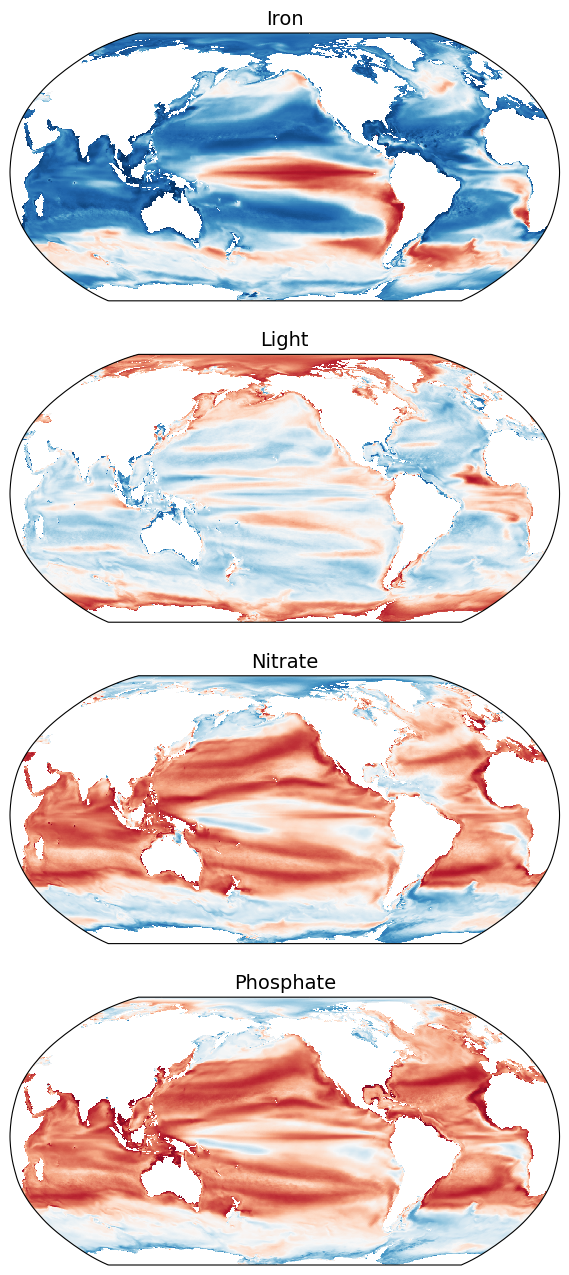

In [13]:
phytotype = 'diat'
lims = [l[:-4] for l in cr.data_vars if phytotype in l]

fig,ax = plt.subplots(nrows=len(lims),
                      figsize=(12,4*len(lims)),
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-150)})
for i,lim in enumerate(lims):
    varnow = lim+phytotype
    axnow = ax.flat[i]
    danow = cr[varnow]
    im = axnow.pcolormesh(grid['geolon'],grid['geolat'],danow,
                          cmap='RdBu_r',
                          transform=ccrs.PlateCarree())
    axnow.set_title(limitations[lim]['longname'],fontsize=14)
    im.set_clim([-1,1])
    # if i == len(lims)-1:
    #     plt.colorbar(im,ax=axnow,orientation='horizontal',fraction=0.05)

## Determine which limiting factor dominates

In [144]:
maxlims = xr.Dataset()
limnames = {}
for phytotype in phytotypes:
    lims = [l[:-4] for l in cr.data_vars if phytotype in l]
    variables = [l+phytotype for l in lims]
    limsarray = cr[variables].to_array('lims',name=phytotype).assign_coords({'lims':lims})
    maxlims[phytotype] = limsarray.fillna(-9999).argmax(dim='lims').where(grid['wet']==1)
    limnames[phytotype] = lims

In [147]:
def plot_maxlim(phytotype):
    fig,ax = plt.subplots(figsize=(12,4),
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=-150)})
    danow = maxlims[phytotype]
    limnamesnow = limnames[phytotype]
    colors = [limitations[l]['color'] for l in limnamesnow]
    longnames = [limitations[l]['longname'] for l in limnamesnow]
    cmap = mpl.colors.ListedColormap(colors)
    im = ax.pcolormesh(grid['geolon'],grid['geolat'],danow+0.5,cmap=cmap,transform=ccrs.PlateCarree())
    im.set_clim([0,len(limnamesnow)])
    cb = plt.colorbar(im,ax=ax)
    cb.set_ticks(np.arange(len(limnamesnow))+0.5)
    cb.set_ticklabels(longnames)
    return fig,ax

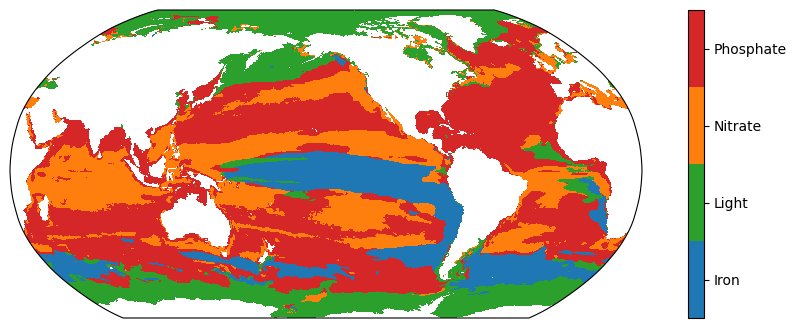

In [148]:
plot_maxlim('diat')

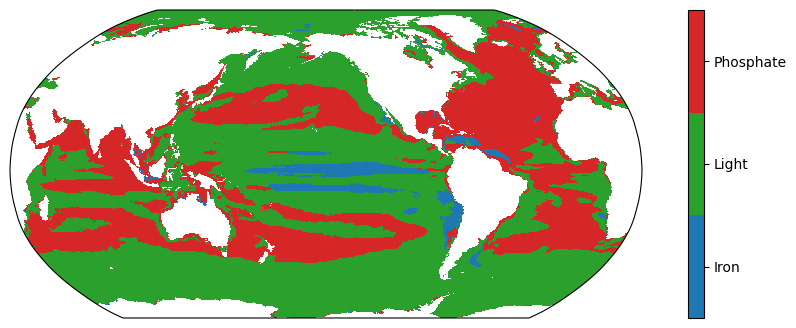

In [149]:
plot_maxlim('diaz')

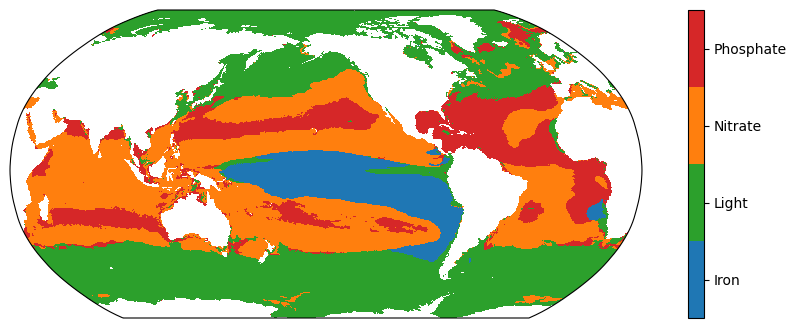

In [150]:
plot_maxlim('pico')

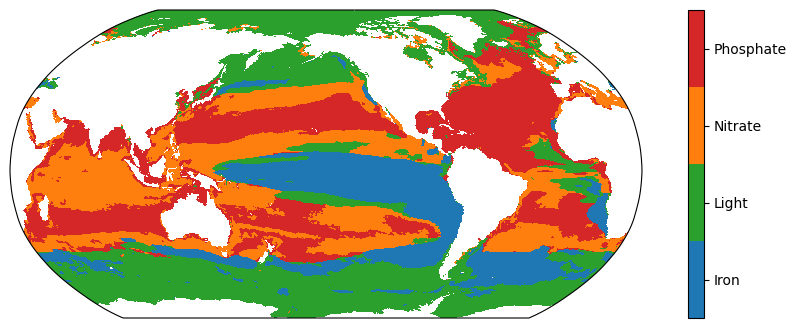

In [151]:
plot_maxlim('misc')